In [1]:
import glob
import os

import geopandas as gpd
import numpy as np
import pandas as pd
from PIL import Image
from PIL.ExifTags import GPSTAGS, TAGS

# Extract Otter data to a point shapefile

The Otter has a GoPro recording video files. Øyvind has extracted individual frames from the videos and geotagged them with the Otter's location.

This notebook assumes that:

 1. The raw Otter images are hosted somewhere on the SeaBee MinIO. For Remoy, Øyvind's images are in `hub-test-bucket/otter_test/2022-08-31_Remoy_All_Day/gopro_images`.
 
 2. I have also downloaded the images locally (because ArcGIS cannot handle images hosted online in non-public locations).
 
The code below generates a point shapefile with one point for every $n$ th image from the Otter. The shapefile attribute table includes a local path for each image (i.e. the location on the user's local computer), making it possible to [configure image popups in ArcGIS Pro](https://pro.arcgis.com/en/pro-app/latest/help/mapping/navigation/configure-pop-ups.htm).

Workflow:

 1. First, make sure you have downloaded the images to your local PC. 
 
 2. Adjust the user settings in section 1 below and run the notebook to create a shapefile for your system.
 
 3. Download the shapefile to your local PC (the one running ArcGIS Pro) and add it to your map.
 
 4. Configure image popups as described [here](https://pro.arcgis.com/en/pro-app/latest/help/mapping/navigation/configure-pop-ups.htm).

In [2]:
def get_exif_data(image_path):
    """Get embedded EXIF data from an image file."""
    exif_data = {}
    img = Image.open(image_path)
    info = img._getexif()
    if info:
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            exif_data[decoded] = value
    return exif_data


def convert_to_degrees(value):
    """Convert GPS coordinates to degrees in float format."""
    d = float(value[0].numerator) / float(value[0].denominator)
    m = float(value[1].numerator) / float(value[1].denominator)
    s = float(value[2].numerator) / float(value[2].denominator)
    return d + (m / 60.0) + (s / 3600.0)


def get_gps_info(exif_data):
    """Extract GPS information from EXIF data."""
    if "GPSInfo" not in exif_data:
        return None

    gps_info = {}
    for key in exif_data["GPSInfo"].keys():
        decode = GPSTAGS.get(key, key)
        gps_info[decode] = exif_data["GPSInfo"][key]

    if (
        "GPSLatitude" in gps_info
        and "GPSLongitude" in gps_info
        and "GPSLatitudeRef" in gps_info
        and "GPSLongitudeRef" in gps_info
    ):
        lat = gps_info["GPSLatitude"]
        lon = gps_info["GPSLongitude"]
        lat_ref = gps_info["GPSLatitudeRef"]
        lon_ref = gps_info["GPSLongitudeRef"]

        lat = convert_to_degrees(lat)
        lon = convert_to_degrees(lon)

        if lat_ref != "N":
            lat = -lat
        if lon_ref != "E":
            lon = -lon

        return lat, lon
    return None

## 1. User input

In [3]:
# Folder containing geotagged GoPro images on MinIO
minio_img_fold = r"/home/notebook/shared-seabee-ns9879k/hub-test-bucket/otter_test/runde_20220901/gopro_images"

# Folder containing the same images downloaded to your local machine
local_img_fold = r"C:\ArcGISprojects\Remoy_2022_updated2024\otter_gopro_images"

# Shapefile to create
shp_path = r"/home/notebook/otter_shapefiles/otter_data_runde_20220901.shp"

# Extract every n-th image e.g. if 'thin' = 20, the shapefile will link every 20th image.
thin = 20

,image_path,lat,lon,geometry
0,C:\Users\JES\Downloads\GoPro_images/2022-09-01...,62.396278,5.655969,POINT (5.65597 62.39628)
1,C:\Users\JES\Downloads\GoPro_images/2022-09-01...,62.396192,5.656331,POINT (5.65633 62.39619)
2,C:\Users\JES\Downloads\GoPro_images/2022-09-01...,62.396092,5.656461,POINT (5.65646 62.39609)
3,C:\Users\JES\Downloads\GoPro_images/2022-09-01...,62.395986,5.656097,POINT (5.65610 62.39599)
4,C:\Users\JES\Downloads\GoPro_images/2022-09-01...,62.395950,5.656133,POINT (5.65613 62.39595)


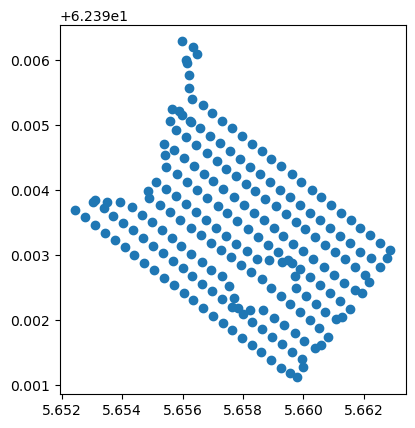

In [4]:
# Identify image files to process
search_path = os.path.join(minio_img_fold, "*_GoPro.jpg")
flist = sorted(glob.glob(search_path))

# Get every n-th file
flist = flist[(thin - 1) :: thin]

# Loop over files
res_dict = {
    "image_path": [],
    "lat": [],
    "lon": [],
}
for fpath in flist:
    fname = os.path.basename(fpath)
    exif_data = get_exif_data(fpath)
    coords = get_gps_info(exif_data)
    if coords:
        lat, lon = coords
    else:
        lat = lon = np.nan
    local_path = os.path.join(local_img_fold, fname)
    res_dict["image_path"].append(local_path)
    res_dict["lat"].append(lat)
    res_dict["lon"].append(lon)
df = pd.DataFrame(res_dict).dropna(subset=["lat", "lon"], how="any")
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df["lon"], df["lat"], crs="EPSG:4326")
)
gdf.to_file(shp_path)

gdf.plot()
gdf.head()